In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from preprocess import load_clean_data, data_stats, create_features, create_features_labels
from plots import plot_validation_diagram, plot_samples, plot_avg, plot_ewma, detect_raw_signal
from IPython.display import display
from keras.models import load_model
from evaluate import evaluate_ae_models, evaluate_seq_models, evaluate_dummy

Using TensorFlow backend.


### Load whole dataset

In [17]:
data = load_clean_data(range(48))

Error while parsing file inxed=2 , [Errno 2] No such file or directory: 'dataset/2.ann.gz'
Error while parsing file inxed=4 , [Errno 2] No such file or directory: 'dataset/4.ann.gz'
Error while parsing file inxed=44 , [Errno 2] No such file or directory: 'dataset/44.ann.gz'


### Show beat types distribution

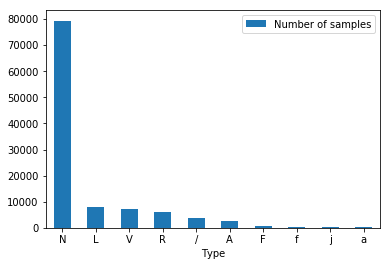

In [3]:
df = data_stats(data)
type_occ = pd.DataFrame(df.sum().sort_values(ascending=False).head(10), columns=['Number of samples'])
type_occ.index.name = 'Type'
type_occ.plot(kind='bar', rot=0);

### Show number of 'A' beat per patient

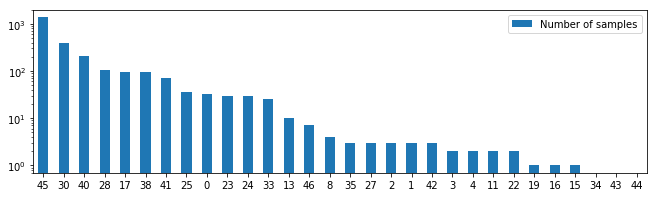

In [4]:
sorted_a = df[['A', 'N']].sort_values(by='A', ascending=False)
sorted_a[['A']][0:30].rename(columns={'A' : 'Number of samples'}).plot(kind='bar', rot = 0, logy=True, figsize=(11,3));

### Split data into train and test set

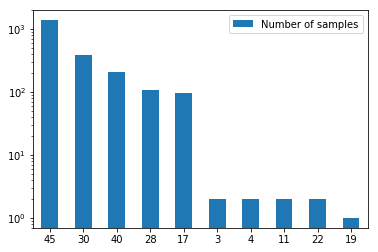

In [5]:
data_index = pd.concat([sorted_a[0:5],sorted_a[20:]])
data_index.head(10)
data_index[['A']][0:10].rename(columns={'A' : 'Number of samples'}).plot(kind='bar', rot = 0, logy=True);

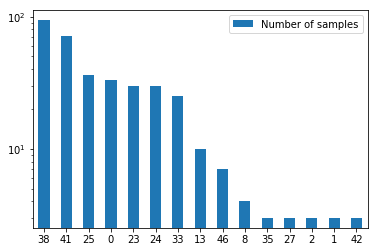

In [6]:
val_index = sorted_a[5:20]
val_index[['A']].rename(columns={'A' : 'Number of samples'}).plot(kind='bar', rot = 0, logy=True);

### Check if the dataset do not intersect

In [7]:
set_d, set_v = set(data_index.index.values), set(val_index.index.values)

In [8]:
set_d.intersection(set_v)

set()

In [9]:
train = data[data_index.index.values]
validation = data[val_index.index.values]

### Investigate sample signals

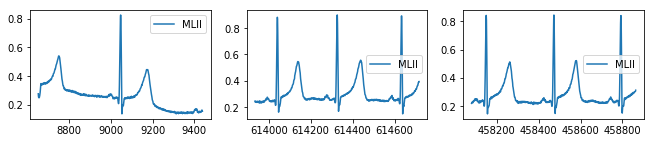

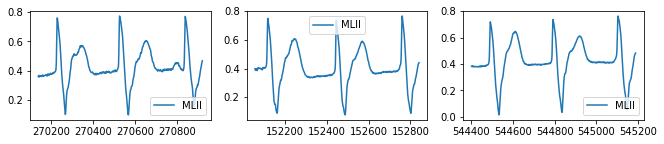

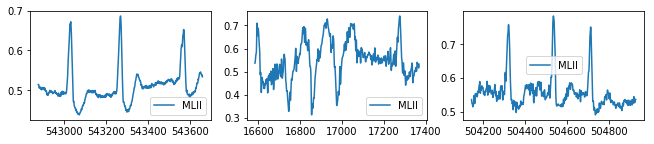

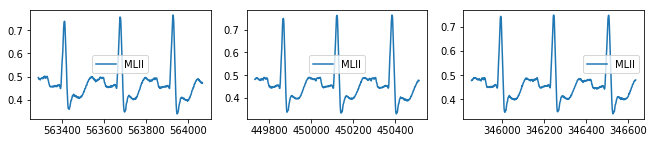

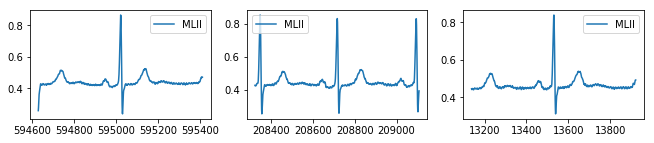

In [156]:
plot_samples(train[-10:-5])

### Plot point of intereset hearbeat in sample beat frame

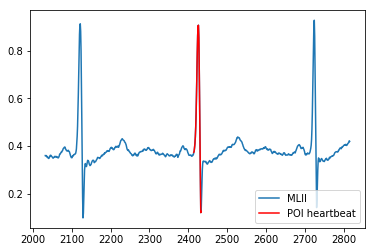

In [29]:
plt.plot(sig['MLII'][2424-392:2424+392])
plt.plot(sig['MLII'][2424-10:2424+10], c='r', label='POI heartbeat')
plt.legend()

In [35]:
#plot_avg(data[16]['signals'], 400)

In [34]:
#plot_ewma(data[16]['signals'], 400)

### Create small train/test set

In [10]:
lb = LabelBinarizer()
non_beats = 1
x_train_all, labels = create_features_labels(data, 784, non_beats_per_beat = non_beats, beat_types=['A', 'N'])
y_train_all = lb.fit_transform(labels)

x_test_all, labels = create_features_labels(validation, 784, non_beats_per_beat = non_beats, beat_types=['A', 'N'])
y_test_all = lb.transform(labels)

In [11]:
x_train_all.shape, x_test_all.shape

((164686, 784), (62040, 784))

In [17]:
df = pd.DataFrame(np.c_[np.sum(y_train_all, axis = 0), np.sum(y_test_all, axis = 0)], index = lb.classes_, columns = ['Train', 'Validation'])
df.index.name = 'Beat type'
display(df)

,Train,Validation
Beat type,,
A,2549,360
N,79794,30660
NB,82343,31020


In [13]:
x_train, _, y_train, _ = train_test_split(x_train_all, y_train_all, test_size = .9)
x_test, _, y_test, _ = train_test_split(x_test_all, y_test_all, test_size = .9)

In [14]:
x_train.shape, x_test.shape

((16468, 784), (6204, 784))

In [15]:
pd.DataFrame(np.c_[np.sum(y_train, axis = 0), np.sum(y_test, axis = 0)], index = lb.classes_, columns = ['Train', 'Test'])

,Train,Test
A,247,39
N,7949,3121
NB,8272,3044


In [54]:
ann = validation[0]['annotations']
sig = validation[0]['signals']

In [146]:
ann[ann['Type'] == 'A'][:10]

,Time,Sample,Type
60,0:49.822,17936,A
376,5:18.703,114733,A
381,5:22.600,116136,A
395,5:34.283,120342,A
472,6:41.181,144425,A
483,6:48.508,147063,A
485,6:49.103,147277,A
486,6:49.544,147436,A
491,6:51.872,148274,A
492,6:52.289,148424,A


### DummyClassifier

In [130]:
dummy = evaluate_dummy(x_train, x_test, y_train, y_test, lb.classes_, ann, sig)

In [132]:
def print_dummy_raport(dummy):
    display(pd.DataFrame(dummy, index = [0], columns=['val_acc', 'precision', 'recall', 'f1_score']).round(2))

In [134]:
print_dummy_raport(dummy)

,val_acc,precision,recall,f1_score
0,0.35,0.33,0.34,0.27


### Check NN autoencoder

Running autoencoder with config: [784, [], 128]


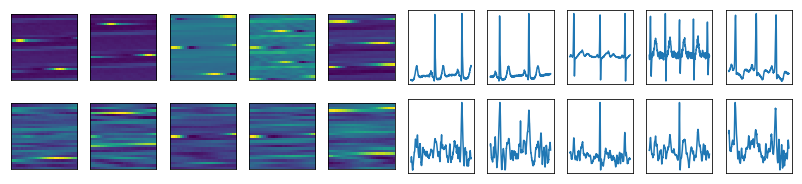

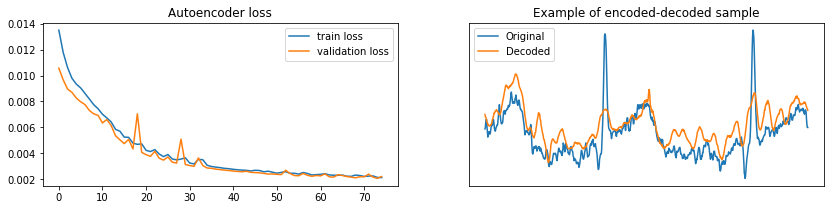

Evaluating model with fc: [3]


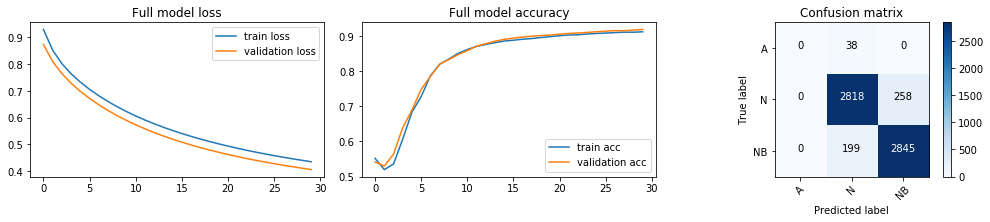

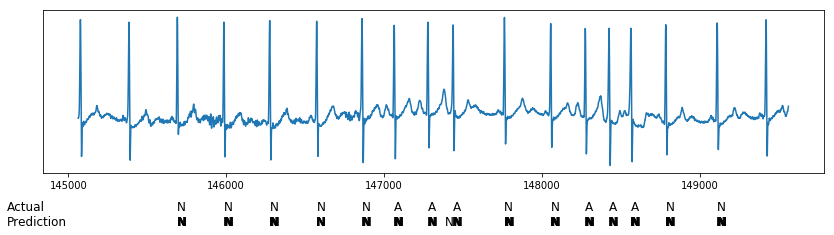

/home/buzz/anaconda2/envs/py3gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Evaluating model with fc: [64, 3]


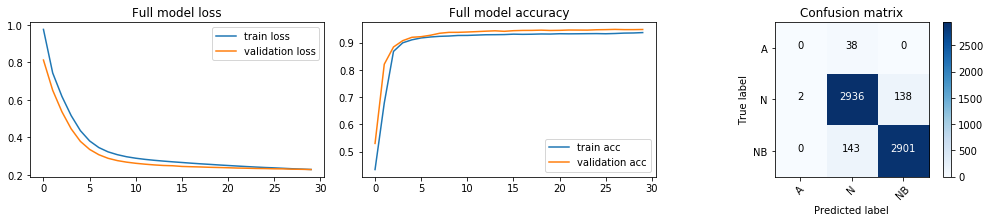

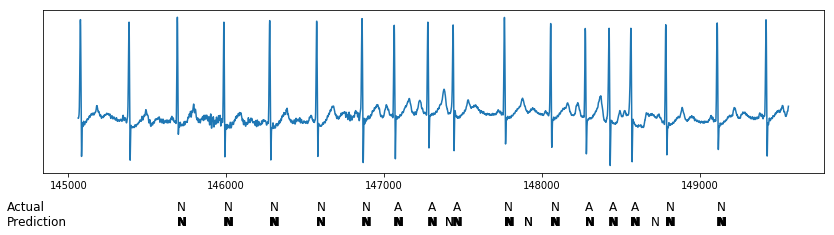

Evaluating model with fc: [128, 3]


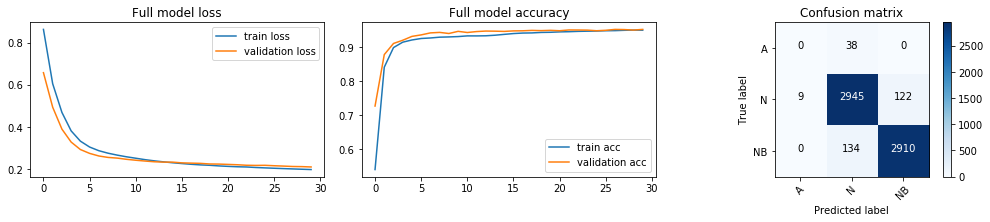

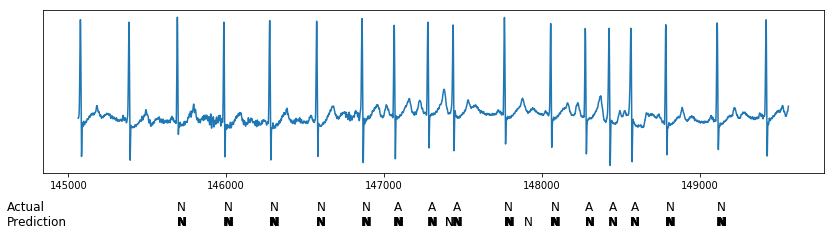

Running autoencoder with config: [784, [256, 128], 64]


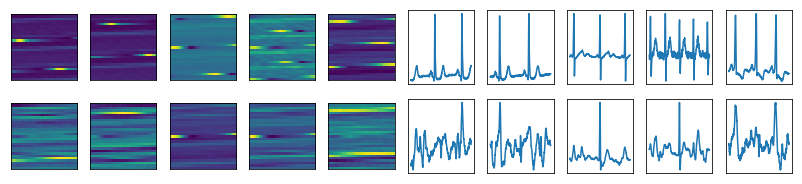

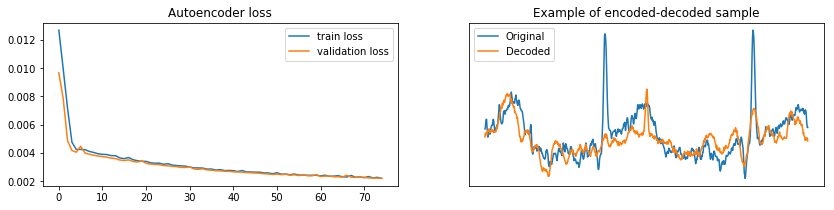

Evaluating model with fc: [3]


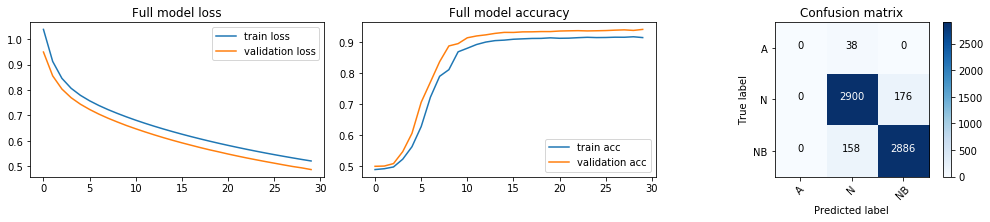

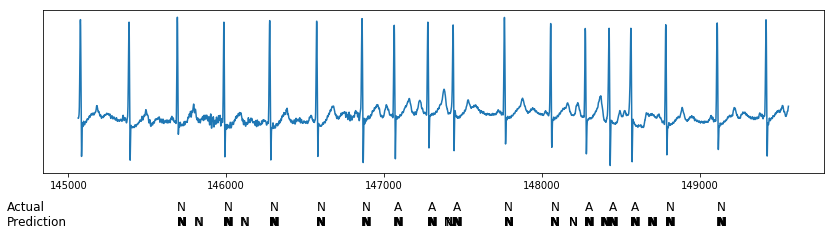

Evaluating model with fc: [64, 3]


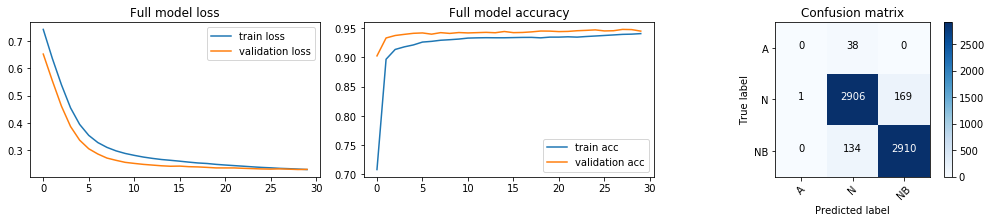

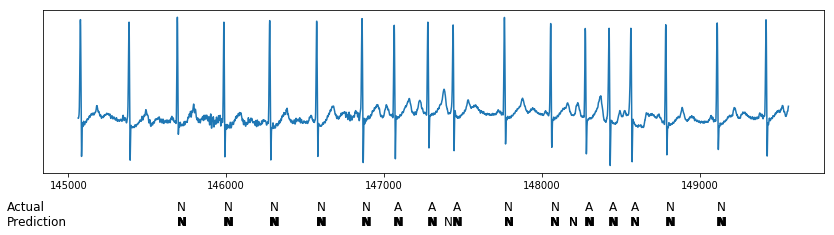

Evaluating model with fc: [128, 3]


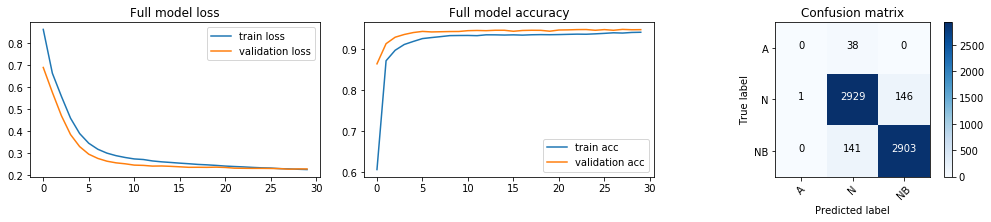

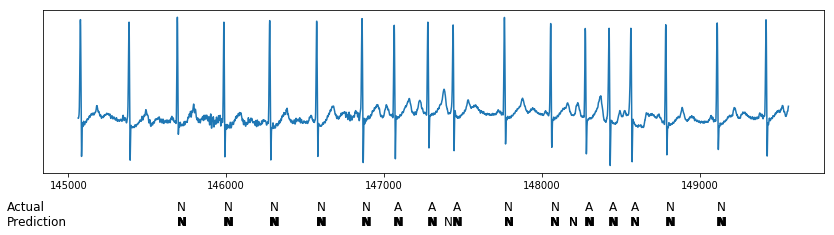

In [218]:
config = {
    'use_conv': False,
#     'ae' : [ [784,[], 128] ],
#     'fc' : [ [3] ]
    'ae' : [ [784,[], 128], [784, [256, 128], 64]],
    'fc' : [ [3], [64,3], [128, 3]]

}
nn_models = evaluate_ae_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                               ae_epochs=75, full_model_epochs=30, load_prev_ae=False, load_prev_full=False)

### Check CONV autoencoder

Running autoencoder with config: [(28, 28), [16, 8, 8], (4, 4)]


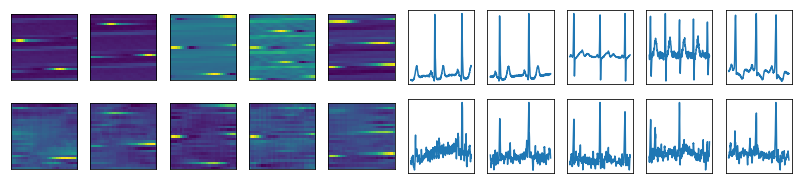

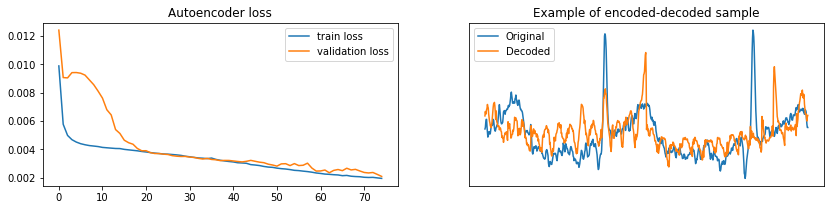

Evaluating model with fc: [3]


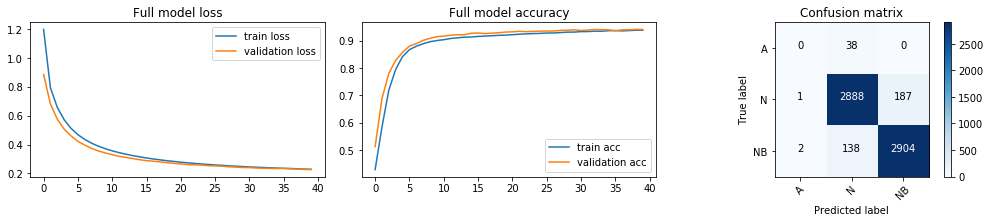

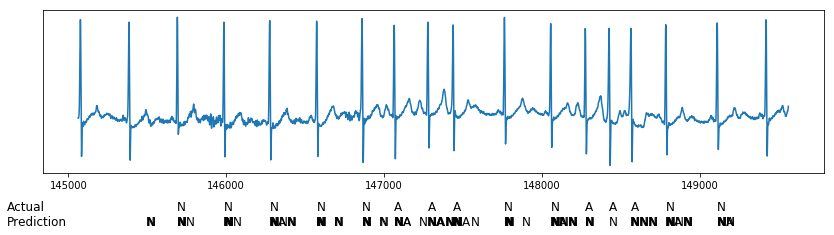

Evaluating model with fc: [64, 3]


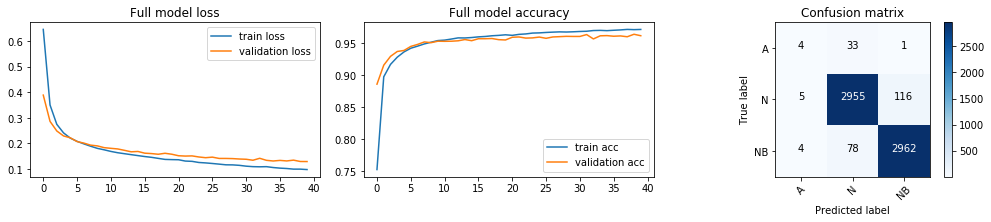

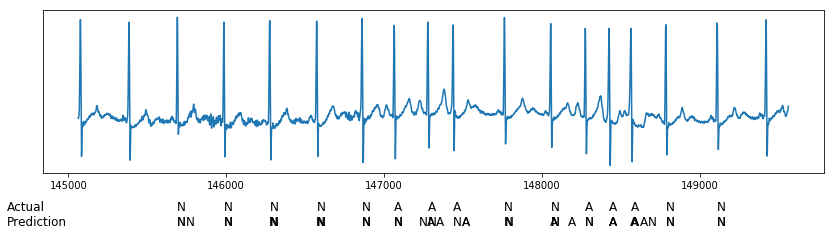

Evaluating model with fc: [128, 3]


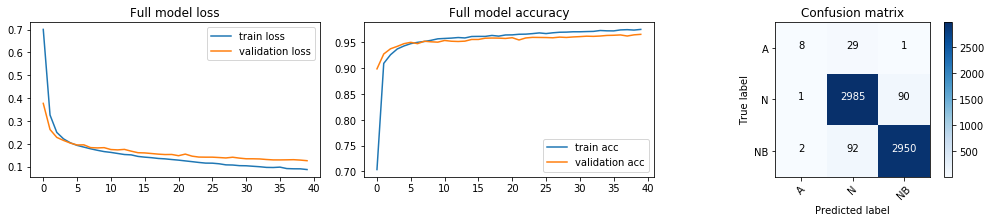

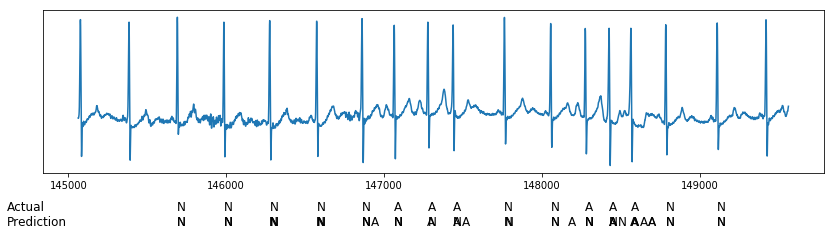

Evaluating model with fc: [1024, 3]


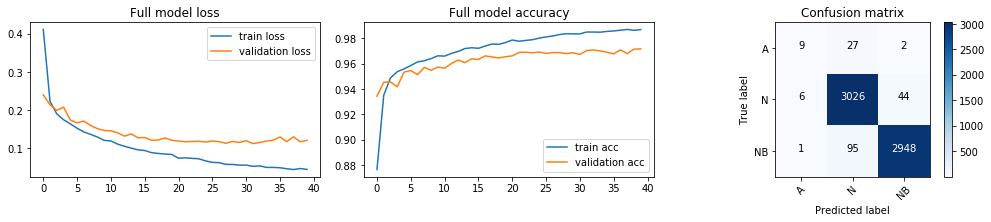

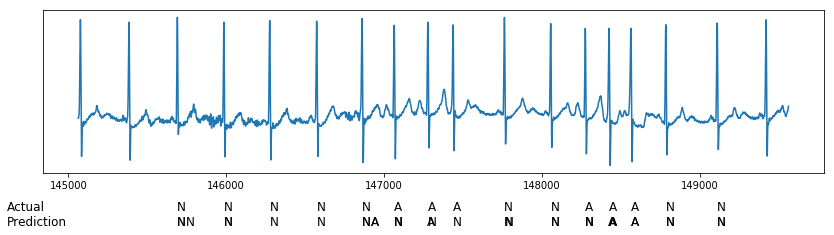

Running autoencoder with config: [(28, 28), [32, 16, 16], (4, 4)]


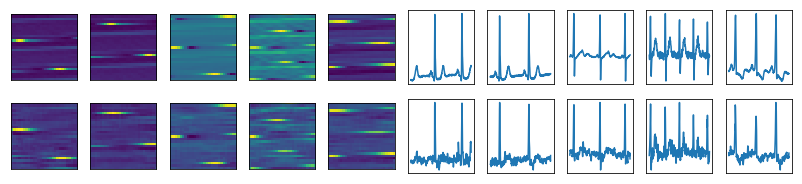

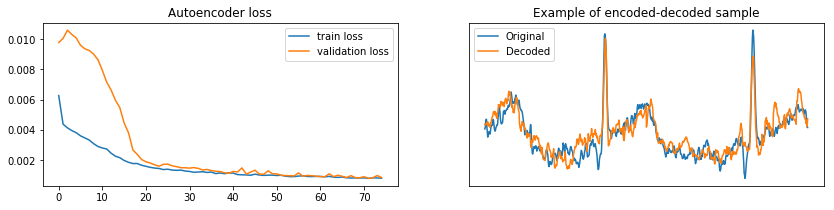

Evaluating model with fc: [3]


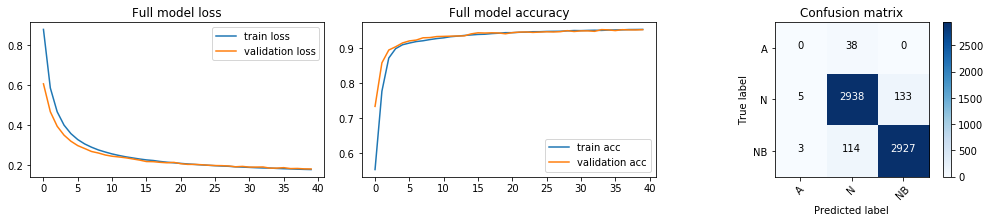

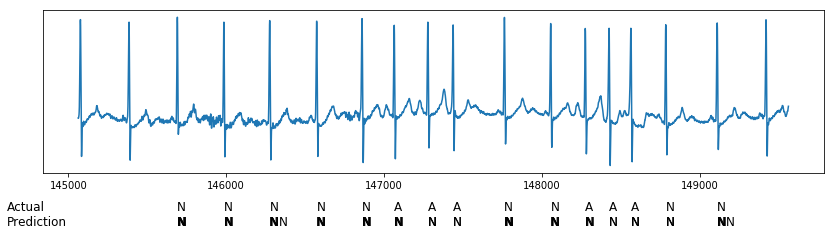

Evaluating model with fc: [64, 3]


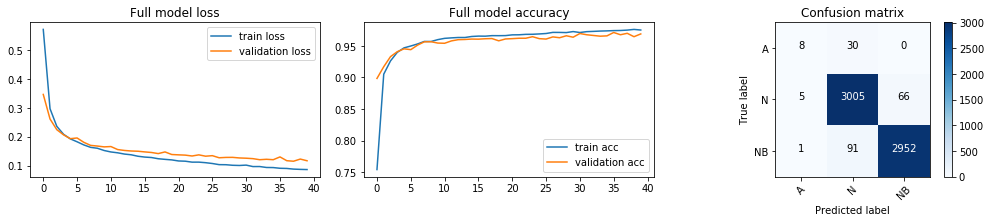

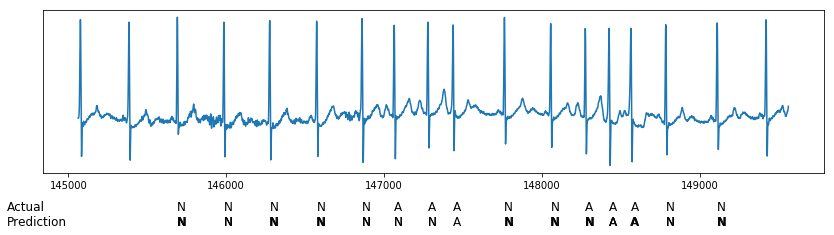

Evaluating model with fc: [128, 3]


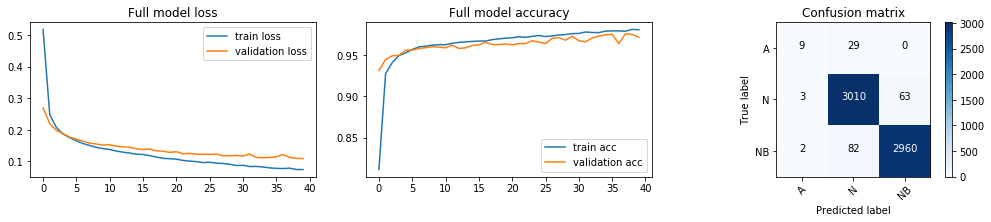

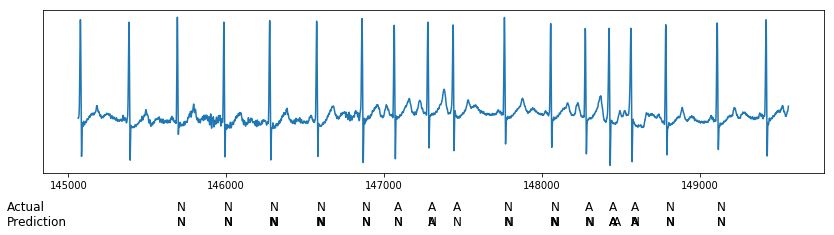

Evaluating model with fc: [1024, 3]


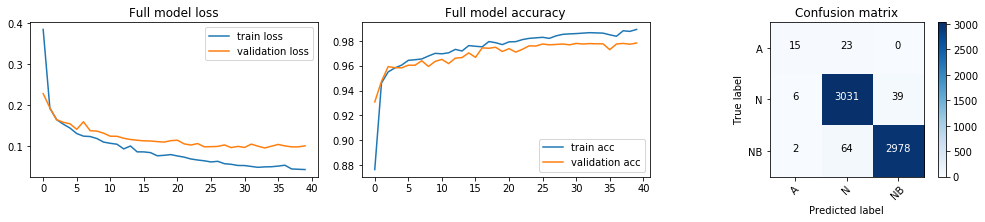

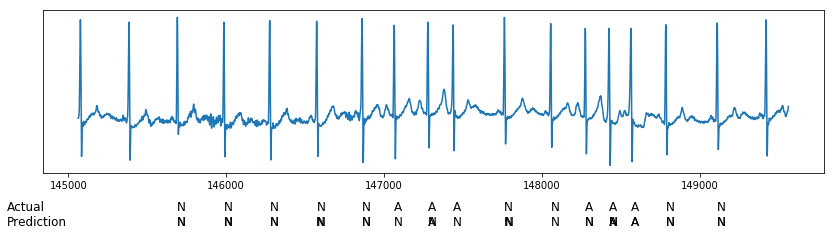

In [219]:
config = {
    'use_conv' : True,
    'ae' : [[(28, 28), [16, 8 , 8], (4,4)], [(28, 28), [32, 16 , 16], (4,4)]],
    'fc' : [ [3], [64,3], [128,3], [1024,3] ]
}
conv_models = evaluate_ae_models(config,  x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                    ae_epochs=75, full_model_epochs=40, load_prev_ae=False, load_prev_full=False)

### Sequential models

Running sequential model: {'filters': [4, 8, 16], 'units': [1024], 'dropout': 0.5}


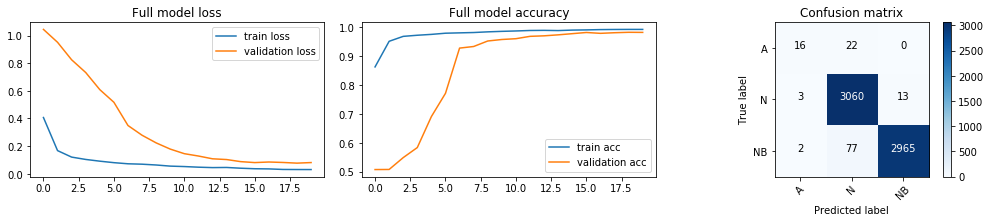

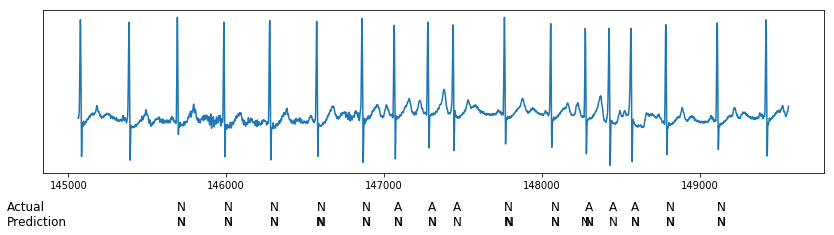

Running sequential model: {'filters': [8, 16, 32], 'units': [1024], 'dropout': 0.5}


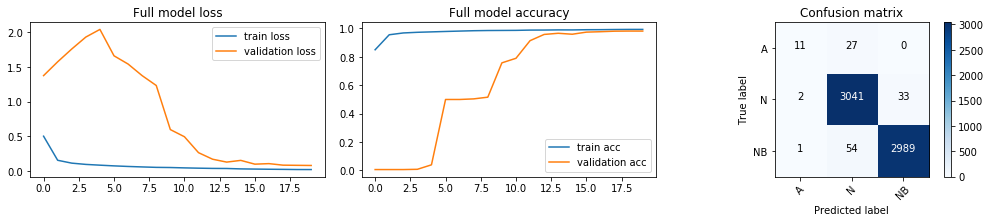

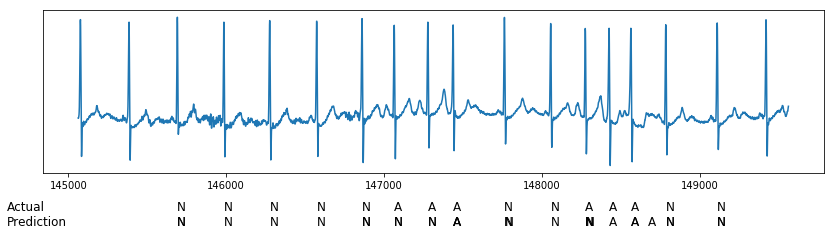

Running sequential model: {'filters': [16, 32, 64], 'units': [1024], 'dropout': 0.5}


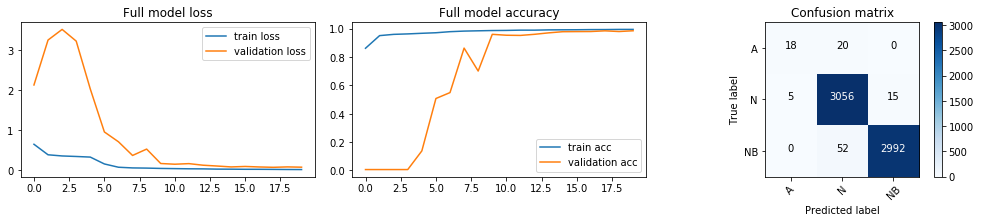

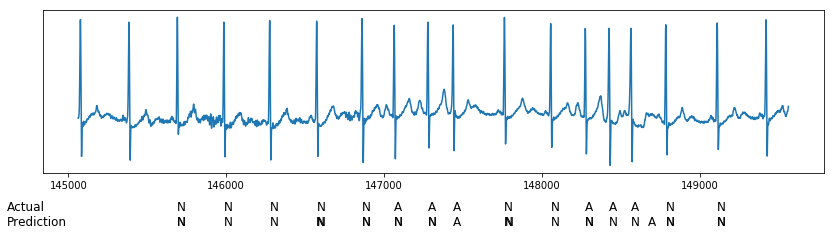

Running sequential model: {'filters': [16, 32, 64], 'units': [2048], 'dropout': 0.5}


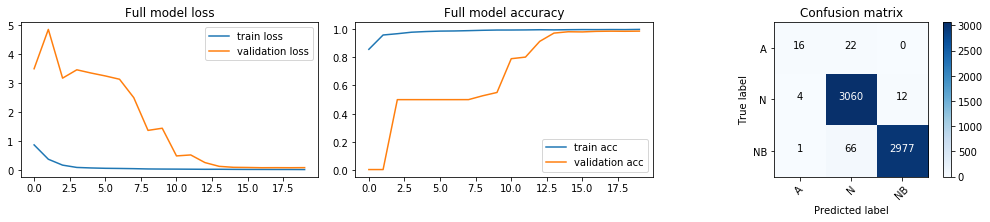

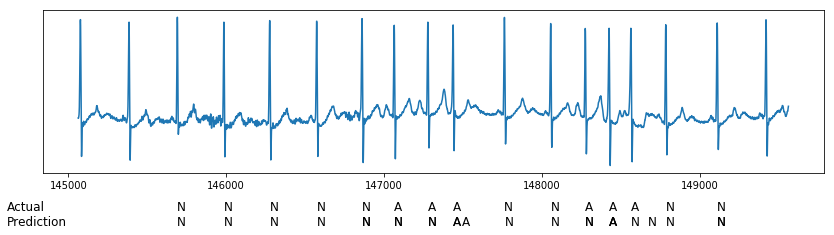

In [220]:
config = [
    {'filters' : [ 4,  8, 16], 'units': [1024, 3], 'dropout': 0.5},
    {'filters' : [ 8, 16, 32], 'units': [1024, 3], 'dropout': 0.5},
    {'filters' : [16, 32, 64], 'units': [1024, 3], 'dropout': 0.5},    
    {'filters' : [16, 32, 64], 'units': [2048, 3], 'dropout': 0.5},
]
seq_models = evaluate_seq_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                 epochs = 20, load_prev=False)

### Print comparison reports for all architectures

In [213]:
def print_raport(result):
    df  = pd.DataFrame(result)
    display(df[['ae', 'fc', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [39]:
def print_seq_raport(result):
    df  = pd.DataFrame(result)    
    display(df[['filters', 'units', 'dropout', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [221]:
print_dummy_raport(dummy), print_raport(nn_models); 

,val_acc,precision,recall,f1_score
0,0.35,0.33,0.34,0.27


,ae,fc,val_acc,precision,recall,f1_score
0,"[784, [], 128]",[3],0.92,0.61,0.62,0.61
1,"[784, [], 128]","[64, 3]",0.95,0.63,0.64,0.63
2,"[784, [], 128]","[128, 3]",0.95,0.63,0.64,0.64
3,"[784, [256, 128], 64]",[3],0.94,0.63,0.63,0.63
4,"[784, [256, 128], 64]","[64, 3]",0.94,0.63,0.63,0.63
5,"[784, [256, 128], 64]","[128, 3]",0.95,0.63,0.64,0.63


In [222]:
print_raport(conv_models)

,ae,fc,val_acc,precision,recall,f1_score
0,"[(28, 28), [16, 8, 8], (4, 4)]",[3],0.94,0.63,0.63,0.63
1,"[(28, 28), [16, 8, 8], (4, 4)]","[64, 3]",0.96,0.74,0.68,0.70
2,"[(28, 28), [16, 8, 8], (4, 4)]","[128, 3]",0.97,0.89,0.72,0.75
3,"[(28, 28), [16, 8, 8], (4, 4)]","[1024, 3]",0.97,0.84,0.73,0.76
4,"[(28, 28), [32, 16, 16], (4, 4)]",[3],0.95,0.64,0.64,0.64
5,"[(28, 28), [32, 16, 16], (4, 4)]","[64, 3]",0.97,0.84,0.72,0.75
6,"[(28, 28), [32, 16, 16], (4, 4)]","[128, 3]",0.97,0.86,0.73,0.76
7,"[(28, 28), [32, 16, 16], (4, 4)]","[1024, 3]",0.98,0.87,0.79,0.82


In [223]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[4, 8, 16]",[1024],0.5,0.98,0.91,0.80,0.84
1,"[8, 16, 32]",[1024],0.5,0.98,0.92,0.75,0.80
2,"[16, 32, 64]",[1024],0.5,0.99,0.92,0.82,0.85
3,"[16, 32, 64]",[2048],0.5,0.98,0.91,0.80,0.84


### Train validate on all data

Running sequential model: {'filters': [16, 32, 64], 'units': [1024], 'dropout': 0.5}
Train on 163598 samples, validate on 61588 samples
Epoch 1/36
163598/163598 [==============================] - 36s - loss: 0.1465 - acc: 0.9649 - val_loss: 0.6171 - val_acc: 0.6836
Epoch 2/36
163598/163598 [==============================] - 34s - loss: 0.0624 - acc: 0.9850 - val_loss: 0.0576 - val_acc: 0.9852
Epoch 3/36
163598/163598 [==============================] - 34s - loss: 0.0546 - acc: 0.9873 - val_loss: 0.0475 - val_acc: 0.9885
Epoch 4/36
163598/163598 [==============================] - 34s - loss: 0.0501 - acc: 0.9885 - val_loss: 0.0575 - val_acc: 0.9864
Epoch 5/36
163598/163598 [==============================] - 34s - loss: 0.0476 - acc: 0.9892 - val_loss: 0.0445 - val_acc: 0.9902
Epoch 6/36
163598/163598 [==============================] - 34s - loss: 0.0452 - acc: 0.9899 - val_loss: 0.0456 - val_acc: 0.9900
Epoch 7/36
163598/163598 [==============================] - 34s - loss: 0.0432 - acc

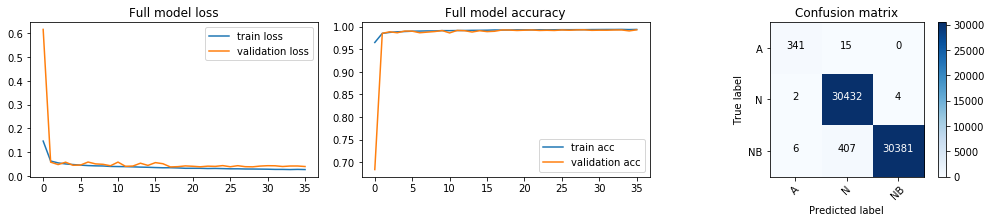

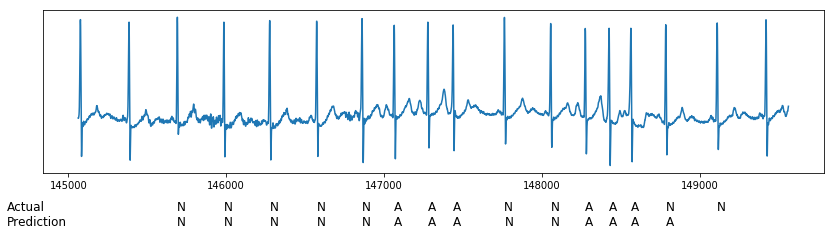

In [42]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024, 3], 'dropout': 0.5},    
]
seq_models = evaluate_seq_models(config, x_train_all, x_test_all, y_train_all, y_test_all, lb.classes_, ann, sig, 
                                 epochs = 36, load_prev=False)

In [43]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]",[1024],0.5,0.99,0.99,0.98,0.98


### Save top model

In [16]:
top_model_path = 'weights/top_model.h5'

In [17]:
top_model = seq_models[0]['model']

NameError: name 'seq_models' is not defined

In [55]:
top_model.save(top_model_path)

In [57]:
lb.classes_

array(['A', 'N', 'NB'],
      dtype='<U2')

### Load top model

In [9]:
top_model_path = 'weights/top_model.h5'

In [10]:
tm = load_model(top_model_path)

### Check localization and classification for various patients for the final model

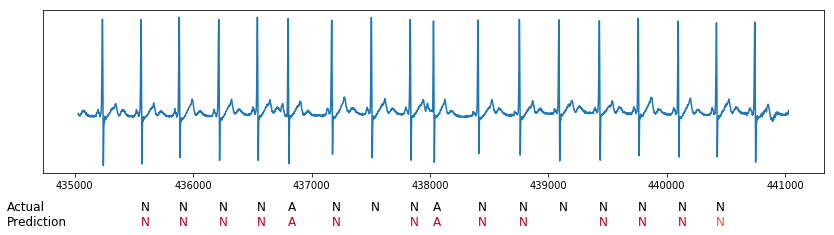

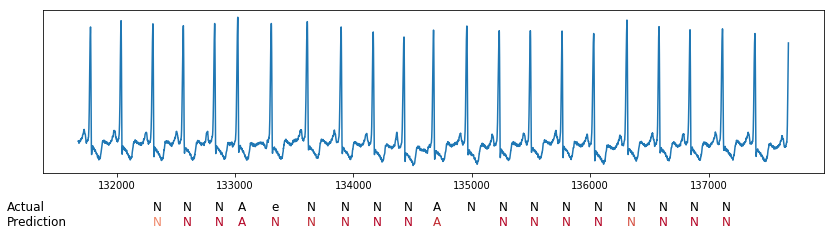

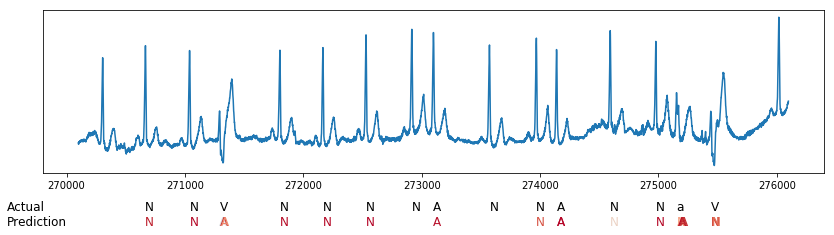

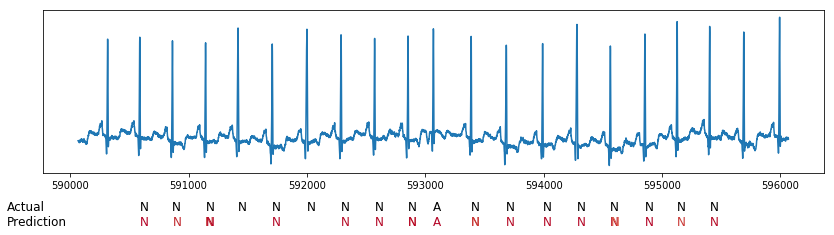

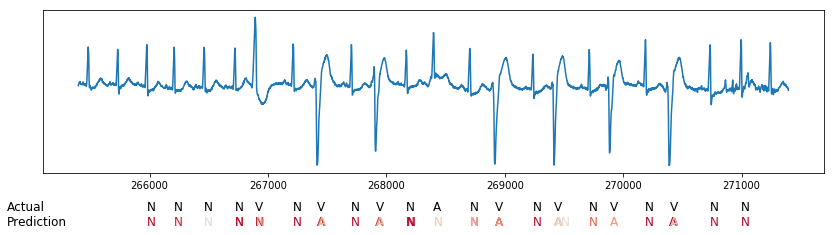

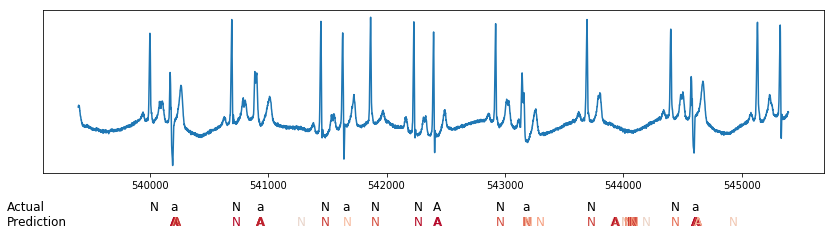

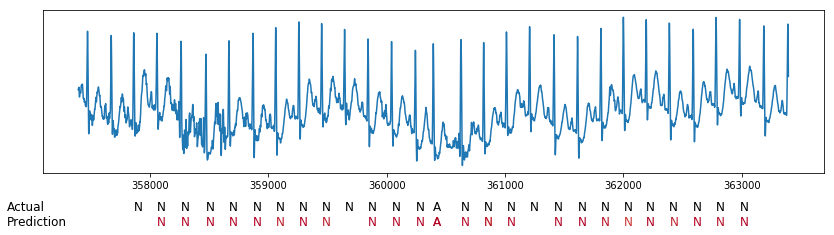

In [35]:
plot_validation_diagrams(tm, lb.classes_, validation)

### Validate model on different dataset

In [15]:
data_index, val_index = sorted_a.index.values, [30,40,28]

In [21]:
data_index = np.delete(data_index, [1,2,3])

### Make sure datasets do not intersect

In [23]:
set_d, set_v = set(data_index), set(val_index)

In [24]:
set_d.intersection(set_v)

set()

In [26]:
train = data[data_index]
validation = data[val_index]

### Split into train and test set

In [27]:
lb = LabelBinarizer()
non_beats = 1
x_train_all, labels = create_features_labels(data, 784, non_beats_per_beat = non_beats, beat_types=['A', 'N'])
y_train_all = lb.fit_transform(labels)

x_test_all, labels = create_features_labels(validation, 784, non_beats_per_beat = non_beats, beat_types=['A', 'N'])
y_test_all = lb.transform(labels)

In [28]:
x_train_all.shape, x_test_all.shape

((163598, 784), (10748, 784))

### Show beat distribution

In [29]:
df = pd.DataFrame(np.c_[np.sum(y_train_all, axis = 0), np.sum(y_test_all, axis = 0)], index = lb.classes_, columns = ['Train', 'Validation'])
df.index.name = 'Beat type'
display(df)

,Train,Validation
Beat type,,
A,2542,697
N,79257,4677
NB,81799,5374


In [30]:
x_train, _, y_train, _ = train_test_split(x_train_all, y_train_all, test_size = .9)
x_test, _, y_test, _ = train_test_split(x_test_all, y_test_all, test_size = .9)

In [31]:
x_train.shape, x_test.shape

((16359, 784), (1074, 784))

In [15]:
pd.DataFrame(np.c_[np.sum(y_train, axis = 0), np.sum(y_test, axis = 0)], index = lb.classes_, columns = ['Train', 'Test'])

,Train,Test
A,247,39
N,7949,3121
NB,8272,3044


In [33]:
ann = validation[0]['annotations']
sig = validation[0]['signals']

### Evaluate top model on alternative dataset

Running sequential model: {'filters': [16, 32, 64], 'units': [1024], 'dropout': 0.5}
Successfully loaded weights
Train on 163598 samples, validate on 10748 samples
Epoch 1/5
163598/163598 [==============================] - 31s - loss: 0.0358 - acc: 0.9922 - val_loss: 0.0902 - val_acc: 0.9785
Epoch 2/5
163598/163598 [==============================] - 31s - loss: 0.0344 - acc: 0.9926 - val_loss: 0.0549 - val_acc: 0.9904
Epoch 3/5
163598/163598 [==============================] - 31s - loss: 0.0323 - acc: 0.9930 - val_loss: 0.0786 - val_acc: 0.9870
Epoch 4/5
163598/163598 [==============================] - 31s - loss: 0.0314 - acc: 0.9932 - val_loss: 0.0580 - val_acc: 0.9905
Epoch 5/5
163598/163598 [==============================] - 32s - loss: 0.0312 - acc: 0.9931 - val_loss: 0.0699 - val_acc: 0.9888


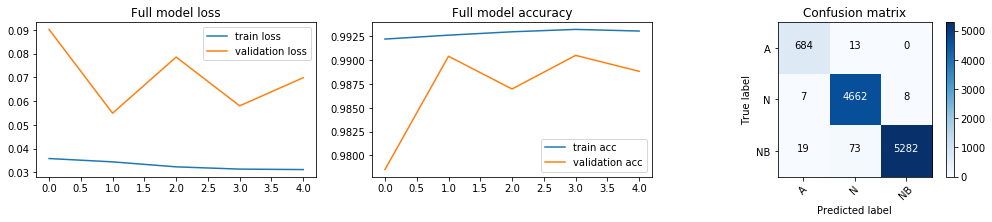

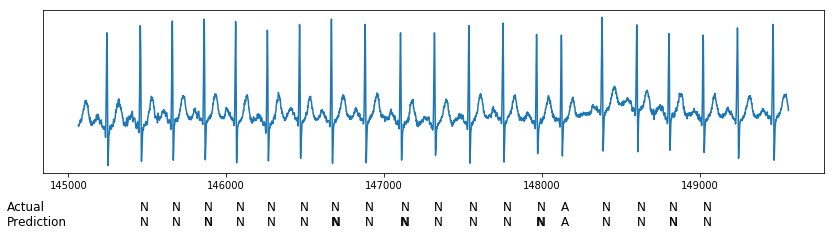

In [38]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024,3], 'dropout': 0.5},    
]
seq_models = evaluate_seq_models(config, x_train_all, x_test_all, y_train_all, y_test_all, lb.classes_, ann, sig, 
                                 epochs = 5, load_prev=True)

### Print metricts

In [40]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]",[1024],0.5,0.99,0.98,0.99,0.98
